In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import gc  # Garbage collector to free memory

# -----------------------------
# CONFIGURATIONS
# -----------------------------
OUTPUT_DIR = "dataset_large"       # Folder to save images + CSV
TOTAL_IMAGES = 5000               # Total dataset size (adjust as needed)
BATCH_SIZE = 1000                  # Number of images per batch
IMG_SIZE = (28, 28)                # Image resolution

os.makedirs(OUTPUT_DIR, exist_ok=True)
csv_path = os.path.join(OUTPUT_DIR, "tx_parameters.csv")

# Initialize CSV storage
if os.path.exists(csv_path):
    os.remove(csv_path)

# -----------------------------
# FUNCTION TO GENERATE WAVEFORM
# -----------------------------
def generate_waveform(frequency, alpha, beta, dielectric, noise_level=0.02):
    """Generate synthetic waveform based on transmission line parameters."""
    t = np.linspace(0, 1, 500)
    signal = np.sin(2 * np.pi * frequency * t + beta)
    signal *= np.exp(-alpha * t)
    noise = noise_level * np.random.randn(len(t))
    signal += noise
    signal = signal / np.max(np.abs(signal))  # Normalize
    return t, signal

# -----------------------------
# BATCH-WISE DATA GENERATION
# -----------------------------
print(f"Generating {TOTAL_IMAGES} waveform images in batches of {BATCH_SIZE}...")

for batch_start in range(0, TOTAL_IMAGES, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, TOTAL_IMAGES)
    batch_data = []

    for i in tqdm(range(batch_start, batch_end), desc=f"Batch {batch_start // BATCH_SIZE + 1}"):
        # Random TX parameters
        frequency = np.random.uniform(1e6, 10e9)        # 1 MHz to 10 GHz
        alpha = np.random.uniform(0.01, 0.5)            # Attenuation
        beta = np.random.uniform(0.1, 2 * np.pi)        # Phase
        dielectric = np.random.uniform(1.5, 12.0)       # Permittivity

        # Generate waveform
        t, signal = generate_waveform(frequency, alpha, beta, dielectric)

        # Save image (faster & memory-safe)
        img_path = os.path.join(OUTPUT_DIR, f"waveform_{i}.png")
        plt.figure(figsize=(3, 3))
        plt.plot(t, signal, color='blue', linewidth=1.2)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(img_path, dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Store metadata
        batch_data.append([f"waveform_{i}.png", frequency, alpha, beta, dielectric])

    # Save batch metadata to CSV
    df = pd.DataFrame(batch_data, columns=["image", "frequency", "alpha", "beta", "dielectric"])
    df.to_csv(csv_path, mode="a", header=not os.path.exists(csv_path), index=False)

    # Free memory
    del batch_data, df
    gc.collect()

    print(f"✅ Saved batch {batch_start // BATCH_SIZE + 1} ({batch_end} images done)")

print(f"\n🎉 Dataset generation complete!")
print(f"📂 Images saved in: {OUTPUT_DIR}")
print(f"📄 Parameters CSV saved at: {csv_path}")


In [ ]:
# robust_cnn_regression.py
import os
import time
import joblib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import StandardScaler

# -------------------- CONFIG --------------------
DATA_DIR = "dataset_large"               # folder with images + tx_parameters.csv
CSV_PATH = os.path.join(DATA_DIR, "tx_parameters.csv")
MODEL_PATH = "waveform_cnn_best.pth"
SCALER_PATH = "label_scaler.pkl"

IMG_SIZE = 64
BATCH_SIZE = 32            # safe for RTX 3050 Ti
EPOCHS = 60
LR = 1e-4
PATIENCE = 8               # early stopping patience on val loss
CLIP_NORM = 1.0            # gradient clipping
VAL_RATIO = 0.1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = torch.cuda.is_available()  # use mixed precision only if GPU

print("Device:", DEVICE, "USE_AMP:", USE_AMP)

# -------------------- READ CSV & PREP LABEL SCALING --------------------
df = pd.read_csv(CSV_PATH)
# Expect CSV columns: [image, frequency, alpha, beta, dielectric]
assert df.shape[1] >= 5, "CSV must contain: filename, frequency, alpha, beta, dielectric"

# prepare lists
filenames = df.iloc[:, 0].astype(str).tolist()
labels_raw = df.iloc[:, 1:5].values.astype(float)  # shape (N,4)

# Transform frequency with log10 to stabilize scale (avoid log(0))
labels_trans = labels_raw.copy()
labels_trans[:, 0] = np.log10(np.maximum(labels_raw[:, 0], 1.0))  # log10(freq)

# Fit a StandardScaler on targets (fit on entire dataset then split; ok for synthetic)
label_scaler = StandardScaler()
labels_scaled_all = label_scaler.fit_transform(labels_trans)
joblib.dump(label_scaler, SCALER_PATH)
print("Saved label scaler to", SCALER_PATH)

# -------------------- TRAIN/VAL SPLIT --------------------
N = len(filenames)
indices = np.arange(N)
np.random.seed(42)
np.random.shuffle(indices)

val_count = int(N * VAL_RATIO)
val_idx = indices[:val_count]
train_idx = indices[val_count:]

train_files = [filenames[i] for i in train_idx]
val_files   = [filenames[i] for i in val_idx]
train_labels = labels_scaled_all[train_idx]
val_labels   = labels_scaled_all[val_idx]

print(f"Total samples: {N}, train: {len(train_files)}, val: {len(val_files)}")

# -------------------- DATASET CLASS --------------------
class WaveformImageDataset(Dataset):
    def __init__(self, file_list, labels_array, img_dir, transform=None):
        self.files = file_list
        self.labels = labels_array
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        fpath = os.path.join(self.img_dir, fname)
        image = Image.open(fpath).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

# -------------------- TRANSFORMS & DATALOADERS --------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                         # -> [0,1]
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  # -> [-1,1]
])

train_dataset = WaveformImageDataset(train_files, train_labels, DATA_DIR, transform=transform)
val_dataset   = WaveformImageDataset(val_files, val_labels, DATA_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=(DEVICE.type=="cuda"))
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=(DEVICE.type=="cuda"))

# -------------------- MODEL --------------------
class WaveformCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Flatten(),
            nn.Linear(256*4*4, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        return self.net(x)

model = WaveformCNN().to(DEVICE)

# weight init
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
model.apply(init_weights)

# -------------------- LOSS, OPTIMIZER, SCHEDULER --------------------
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

scaler = None
if USE_AMP:
    from torch.amp import GradScaler, autocast
    scaler = GradScaler(device="cuda")

# -------------------- TRAIN + VALIDATE --------------------
best_val = float("inf")
best_epoch = -1
start_time = time.time()
no_improve = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    n_train = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]")
    for imgs, lbls in loop:
        imgs = imgs.to(DEVICE, non_blocking=True)
        lbls = lbls.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        if USE_AMP:
            with autocast(device_type="cuda"):
                preds = model(imgs)
                loss = criterion(preds, lbls)
            scaler.scale(loss).backward()
            # gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            preds = model(imgs)
            loss = criterion(preds, lbls)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()

        train_loss += float(loss.item()) * imgs.size(0)
        n_train += imgs.size(0)
        loop.set_postfix(train_loss=train_loss / n_train)

    train_loss = train_loss / n_train

    # validation
    model.eval()
    val_loss = 0.0
    n_val = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            lbls = lbls.to(DEVICE, non_blocking=True)
            if USE_AMP:
                with autocast(device_type="cuda"):
                    preds = model(imgs)
                    loss = criterion(preds, lbls)
            else:
                preds = model(imgs)
                loss = criterion(preds, lbls)
            val_loss += float(loss.item()) * imgs.size(0)
            n_val += imgs.size(0)
    val_loss = val_loss / n_val

    print(f"Epoch {epoch}: train_loss={train_loss:.6e}, val_loss={val_loss:.6e}")

    # scheduler step (ReduceLROnPlateau)
    scheduler.step(val_loss)

    # early stopping & save best
    if val_loss < best_val - 1e-12:
        best_val = val_loss
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Saved best model (epoch {epoch}) val_loss={val_loss:.6e}")
    else:
        no_improve += 1
        print(f"No improvement count: {no_improve}/{PATIENCE}")

    if no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break

total_time = time.time() - start_time
print(f"Training finished. Best epoch: {best_epoch}, best val loss: {best_val:.6e}, total_time={total_time:.1f}s")

# -------------------- HELPER: Prediction (loads scaler & model) --------------------
def load_model_and_scaler(model_path=MODEL_PATH, scaler_path=SCALER_PATH, device=DEVICE):
    m = WaveformCNN().to(device)
    m.load_state_dict(torch.load(model_path, map_location=device))
    m.eval()
    scl = joblib.load(scaler_path)
    return m, scl

def predict_image(image_path, model_obj, scaler_obj, img_size=IMG_SIZE, device=DEVICE):
    trans = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
    img = Image.open(image_path).convert("RGB")
    x = trans(img).unsqueeze(0).to(device)
    with torch.no_grad():
        if USE_AMP:
            from torch.amp import autocast
            with autocast(device_type="cuda"):
                pred_scaled = model_obj(x).cpu().numpy()
        else:
            pred_scaled = model_obj(x).cpu().numpy()
    # inverse scale and inverse log on frequency
    pred_unscaled = scaler_obj.inverse_transform(pred_scaled)
    pred_unscaled[:,0] = 10 ** pred_unscaled[:,0]  # inverse log10 frequency
    return pred_unscaled.flatten()

# Example usage after training:
# model_loaded, scaler_loaded = load_model_and_scaler()
# print(predict_image("dataset_large/waveform_0.png", model_loaded, scaler_loaded))


In [1]:
# predict_single_compare.py
import os
import joblib
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms

# ====== CONFIG ======
DATA_DIR    = "dataset_large"
CSV_PATH    = os.path.join(DATA_DIR, "tx_parameters.csv")
MODEL_PATH  = "waveform_cnn_best.pth"
SCALER_PATH = "label_scaler.pkl"
IMG_SIZE    = 64
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ====================

# ====== Model ======
class WaveformCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Flatten(),
            nn.Linear(256*4*4, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 4)
        )
    def forward(self, x):
        return self.net(x)

# ====== Load model + scaler ======
def load_model_and_scaler():
    model = WaveformCNN().to(DEVICE)
    state = torch.load(MODEL_PATH, map_location=DEVICE)
    if isinstance(state, dict):
        model.load_state_dict(state)
    else:
        model.load_state_dict(state.state_dict())
    model.eval()
    scaler = joblib.load(SCALER_PATH)
    return model, scaler

# ====== Transform ======
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# ====== Predict ======
def predict_image(image_path, model, scaler):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out_scaled = model(x).cpu().numpy()
    out_unscaled = scaler.inverse_transform(out_scaled)
    out_unscaled[0,0] = 10 ** out_unscaled[0,0]  # undo log10
    return out_unscaled.flatten()

# ====== Compare actual vs predicted ======
def compare_with_actual(image_name):
    # Load model & scaler
    model, scaler = load_model_and_scaler()
    image_path = os.path.join(DATA_DIR, image_name)
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Predict
    pred = predict_image(image_path, model, scaler)

    # Load CSV and lookup actual
    df = pd.read_csv(CSV_PATH)
    img_col = df.columns[0]     # first col = image filename
    label_cols = df.columns[1:5]
    match = df[df[img_col] == image_name]
    if match.empty:
        raise ValueError(f"No entry found in CSV for image {image_name}")
    actual = match[label_cols].values[0].astype(float)

    # Print comparison
    print(f"\nImage: {image_name}")
    print("  Actual   -> Frequency: {:.6e}, Alpha: {:.6e}, Beta: {:.6e}, Dielectric: {:.6e}".format(*actual))
    print("  Predicted-> Frequency: {:.6e}, Alpha: {:.6e}, Beta: {:.6e}, Dielectric: {:.6e}".format(*pred))

if __name__ == "__main__":
    # 👇 change this to the exact filename listed in tx_parameters.csv
    compare_with_actual("waveform_1171.png")


C:\Users\adity\AppData\Local\Temp\ipykernel_6404\3538949242.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=DEVICE)



Image: waveform_1171.png
  Actual   -> Frequency: 3.643486e+09, Alpha: 4.146149e-01, Beta: 1.282216e+00, Dielectric: 6.168387e+00
  Predicted-> Frequency: 3.664618e+09, Alpha: 4.142339e-01, Beta: 1.224765e+00, Dielectric: 6.564790e+00


C:\Users\adity\AppData\Local\Temp\ipykernel_6404\3538949242.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=DEVICE)
100%|███

Best sample: waveform_1171.png, Mean error: 2.89%


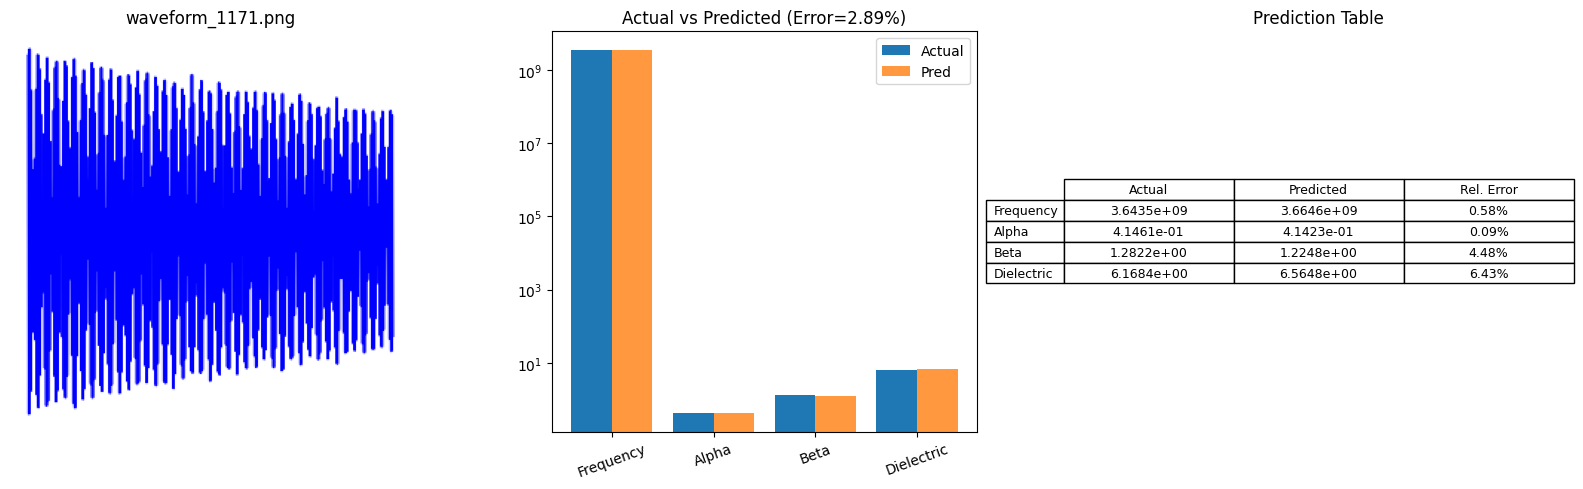

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# === Load model and scaler ===
model, scaler = load_model_and_scaler()
df = pd.read_csv(CSV_PATH)

# Store accurate samples
accurate_samples = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_name = row["image"]
    img_path = os.path.join(DATA_DIR, img_name)

    # Ground truth
    gt = row[["frequency", "alpha", "beta", "dielectric"]].values.astype(float)

    # Prediction
    pred = predict_image(img_path, model, scaler)

    # Mean relative error
    denom = np.maximum(np.abs(gt), 1e-9)
    rel_error = np.abs(pred - gt) / denom
    mean_error = rel_error.mean()

    if mean_error <= 0.05:  # ≥95% accuracy
        accurate_samples.append((img_name, gt, pred, rel_error, mean_error))

# Sort by best accuracy
accurate_samples.sort(key=lambda x: x[4])

# Pick the most accurate one
best_img, best_gt, best_pred, rel_err, mean_err = accurate_samples[0]
print(f"Best sample: {best_img}, Mean error: {mean_err*100:.2f}%")

# === Plot ===
labels = ["Frequency", "Alpha", "Beta", "Dielectric"]

fig, axes = plt.subplots(1, 3, figsize=(16,5))

# Show waveform
axes[0].imshow(Image.open(os.path.join(DATA_DIR, best_img)))
axes[0].axis("off")
axes[0].set_title(best_img)

# Bar chart: Actual vs Predicted
x = np.arange(len(labels))
axes[1].bar(x - 0.2, best_gt, width=0.4, label="Actual", color="tab:blue")
axes[1].bar(x + 0.2, best_pred, width=0.4, label="Pred", color="tab:orange", alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=20)
axes[1].set_yscale("log")
axes[1].set_title(f"Actual vs Predicted (Error={mean_err*100:.2f}%)")
axes[1].legend()

# Table with values
cell_data = []
for i, label in enumerate(labels):
    cell_data.append([
        f"{best_gt[i]:.4e}", 
        f"{best_pred[i]:.4e}", 
        f"{rel_err[i]*100:.2f}%"
    ])

table = axes[2].table(
    cellText=cell_data,
    colLabels=["Actual", "Predicted", "Rel. Error"],
    rowLabels=labels,
    loc="center",
    cellLoc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)
axes[2].axis("off")
axes[2].set_title("Prediction Table")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Clean vertical CNN diagram
fig, ax = plt.subplots(figsize=(6, 10))

layers = [
    ("Input\n64x64x3", "skyblue"),
    ("Conv2D+BN+ReLU\n32 filters", "lightgreen"),
    ("MaxPool 2x2", "lightyellow"),
    ("Conv2D+BN+ReLU\n64 filters", "lightgreen"),
    ("MaxPool 2x2", "lightyellow"),
    ("Conv2D+BN+ReLU\n128 filters", "lightgreen"),
    ("MaxPool 2x2", "lightyellow"),
    ("Conv2D+BN+ReLU\n256 filters", "lightgreen"),
    ("AdaptiveAvgPool\n4x4", "lightcoral"),
    ("Flatten", "lightgrey"),
    ("FC 4096→512\nReLU + Dropout", "orange"),
    ("FC 512→128\nReLU + Dropout", "orange"),
    ("FC 128→4\nOutput", "tomato"),
]

x, y = 0, 0
for i, (text, color) in enumerate(layers):
    box = mpatches.FancyBboxPatch((x, y), 3, 1, boxstyle="round,pad=0.2", fc=color, ec="black", lw=1.2)
    ax.add_patch(box)
    ax.text(x + 1.5, y + 0.5, text, ha="center", va="center", fontsize=10, weight="bold")
    if i < len(layers) - 1:
        ax.arrow(x + 1.5, y - 0.05, 0, -0.9, head_width=0.2, head_length=0.2, fc="black", ec="black")
    y -= 1.5

ax.set_xlim(-1, 5)
ax.set_ylim(-len(layers)*1.5, 2)
ax.axis("off")
plt.title("WaveformCNN Architecture", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig("cnn_architecture_clean.png", dpi=300)
plt.show()
